## Project 1: Classification of ENSO extreme phases through SST data

## Data read + plotting NINO3.4

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

#nice figures
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans']
mpl.rcParams['font.size'] = 12

Text(0, 0.5, 'NINO3.4')

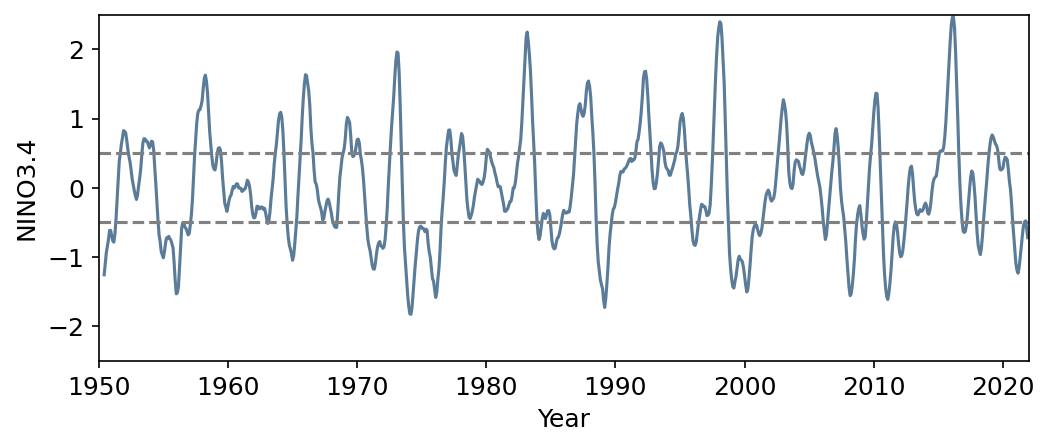

In [2]:
#path = r '/Users/areti/OneDrive/Desktop/UU/block_4/Advanced_topics/ATCD_myrep/ATCD_2025_UU/'
filename ="ERSSTv5_deseasoneddetrended_5monthrunningmean_1950-2021.nc"
sstds = xr.open_dataset(filename)
sst = sstds.sst
time = sstds.time

ninolat1 = -5
ninolat2 = 5
ninolon1 = 190
ninolon2 = 240

sstnino = np.asarray(sst.sel(lat=slice(ninolat1,ninolat2),lon=slice(ninolon1,ninolon2)))
nino34 = np.nanmean(sstnino,axis=(1,2))
timevec = np.arange(1950+(5/12),2022,1/12)

plt.figure(figsize=(8,3))
plt.plot(timevec,nino34,color='xkcd:slate blue')
plt.hlines(0.5,1950,2022,linestyle='dashed',color='grey')
plt.hlines(-0.5,1950,2022,linestyle='dashed',color='grey')
plt.xlim(1950,2022)
plt.ylim(-2.5,2.5)
plt.xlabel("Year")
plt.ylabel("NINO3.4")
#plt.show()

In [3]:
elnino_idx = np.where(nino34>0.5)
lanina_idx = np.where(nino34< -0.5)
events_idx = np.where((nino34> 0.5) | (nino34< -0.5))

In [4]:
elnino = sst[elnino_idx]
lanina = sst[lanina_idx]

In [5]:
events = sst[events_idx]

In [6]:
data= sstds
#data = data.sst.fillna(0)
Nino34 = xr.DataArray(nino34, dims=('time'), name='nino34')
timevec = xr.DataArray(timevec, dims=('time'), name='timevec')
class_bin = xr.DataArray(np.full(nino34.shape, np.nan), dims=('time'), name='class')
# Add it to the dataset
data["timevec"] = timevec
data["nino34"] = Nino34
data["class"] = class_bin
data["class"][elnino_idx] = 1
data["class"][lanina_idx] = 0 
data= data.dropna(dim='time', subset=['class'])

# Identify El Nino and La Nina events and create a binary class

### Split data into training, validation and testing datasets

In [7]:
training = data.sel(time=(data.time.dt.year >= 1950) & (data.time.dt.year <= 2000))
validation = data.sel(time=(data.time.dt.year > 2000) & (data.time.dt.year <= 2010))
testing = data.sel(time=(data.time.dt.year > 2010) & (data.time.dt.year <= 2021))

Text(0, 0.5, 'NINO3.4')

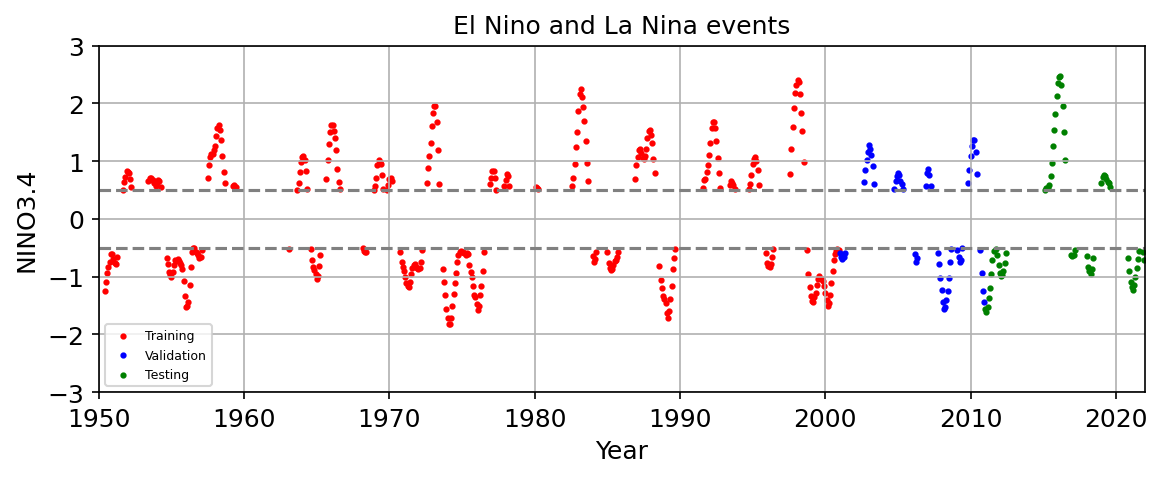

In [8]:
plt.figure(figsize=(9,3))
#training.nino34.plot()
plt.title('El Nino and La Nina events', fontsize =12)
plt.scatter(training.timevec,training.nino34.values,color='red', label = 'Training', s =4)
plt.scatter(validation.timevec,validation.nino34.values,color='blue', label = 'Validation', s =4)
plt.scatter(testing.timevec,testing.nino34,color='green', label = 'Testing', s =4)
plt.hlines(0.5,1950,2022,linestyle='dashed',color='grey')
plt.hlines(-0.5,1950,2022,linestyle='dashed',color='grey')
plt.xlim(1950,2022)
plt.legend(loc = 'lower left', fontsize =6)
plt.ylim(-3,3)
plt.grid()
plt.xlabel("Year")
plt.ylabel("NINO3.4")

### Standartize the sst data

In [9]:
def stand(dataset, ref_data ):
    
    sd   = ref_data.sst.std('time')
    mean = ref_data.sst.mean('time')
    stand = (dataset.sst - mean)/sd
    stand = stand.fillna(0)
    
    return stand  

In [10]:
training_sd   = stand(training,training)
validation_sd = stand(validation,training)
testing_sd    = stand(testing,training)

C:\Users\areti\anaconda3\envs\atcd\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\areti\anaconda3\envs\atcd\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\areti\anaconda3\envs\atcd\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


### Prepare the data for the neural network 

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional


In [12]:
training_sd.values.shape

(340, 89, 180)

In [13]:
def prep_data(ds):
    ds =  ds.values 
    ds_flat = ds.reshape(ds.shape[0], ds.shape[1] * ds.shape[2])
    return ds_flat 

In [14]:
dataset = prep_data(training_sd)
valid_ds = prep_data(validation_sd)
test_ds = prep_data(testing_sd)
dataset.shape

(340, 16020)

In [15]:
class_labels = training['class'].values

In [16]:
class_labels.shape

(340,)

In [18]:
data=torch.from_numpy(dataset).to(torch.float32)
labels=torch.from_numpy(class_labels).long()
labels=functional.one_hot(labels).to(torch.float32)

class customDataset(Dataset):
    def __init__(self,data,labels):
        self.data=data
        self.labels=labels
    def __getitem__(self,idx):
        return self.data[idx],self.labels[idx]
    def __len__(self):
        return self.data.shape[0]


In [19]:
custom_dataset=customDataset(data,labels)

In [20]:
idx=0
print("total length dataset:{}".format(custom_dataset.__len__()))
print("{}th element in the dataset is:{}".format(idx,custom_dataset.__getitem__(idx)[0]))
print("with corresponding label:{}".format(custom_dataset.__getitem__(idx)[1]))

total length dataset:340
0th element in the dataset is:tensor([0., 0., 0.,  ..., 0., 0., 0.])
with corresponding label:tensor([1., 0.])


### Define data loader

In [21]:
#We split our data into batches 
Data_loader=DataLoader(custom_dataset, batch_size= 32 ,shuffle=False)
#for x,y in Data_loader:
    #print(x.shape)
    #print(y.shape)

# Define Freedworward Neural Network

In [22]:
# Device configuration
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

device = "coda" if torch.backends.mps.is_available() else "cpu"
device = torch.device(device)
print(f"Using device: {device}")

Is MPS (Metal Performance Shader) built? False
Is MPS available? False
Using device: cpu


In [24]:

from torch import nn

class MLP(nn.Module):
    def __init__(self,hid_layers_dim,input_dim,output_dim):
        'define layers and parameters of our network'
        super(MLP, self).__init__()
        #first hidden layer
        self.fc1=nn.Linear(input_dim,hid_layers_dim)
        self.act1=nn.ReLU()
        #second hidden layer
        self.fc2=nn.Linear(hid_layers_dim,hid_layers_dim)
        self.act2=nn.ReLU()
        
        self.output_layer=nn.Linear(hid_layers_dim,output_dim)
        #self.act_output=nn.Softmax(dim=1)
        
    def forward(self,x):
        'Executed every time we call the module'
        x=self.fc1(x)
        x=self.act1(x)
        x=self.fc2(x)
        x=self.act2(x)
        x=self.output_layer(x)
       # x=self.act_output(x)
    
        return x

in_dim = dataset.shape[1] #input dims
n_h = 12 # neurons of hidden layer
n_o = 2 # output nodes
mlp=MLP(hid_layers_dim=n_h, input_dim=in_dim, output_dim= n_o )
result=mlp(data)
print(result.shape)

torch.Size([340, 2])


### Training the network 

In [25]:
criterion=torch.nn.CrossEntropyLoss()

In [26]:
from torch.optim import Adam
learn_rate= 1e-3 #learning rate η  
beta = 1e-5  #ridge regularization 
optimizer=Adam(mlp.parameters(),lr = learn_rate, weight_decay = beta)

In [27]:
import tqdm
n_epochs=10
mlp.train()
mlp.to(device)

# Training loop
for epoch in range(n_epochs): # 1 epoch = one full pass over the entire dataset (all the batches) 
    print("epoch:{}".format(epoch))
    loss_current_epoch=[]
    for data_inputs, data_labels in Data_loader: # Dataloader basically holds all the batches and each time we get one batch, follow all the steps then move on to the next batch)

        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        preds = mlp(data_inputs)
        preds = preds.squeeze(dim=1)

        loss = criterion(preds, data_labels)
        
        loss_current_epoch.append(loss.item())
        optimizer.zero_grad() # Clear previous gradients
        loss.backward()

        optimizer.step() #gradient descent update
    
    print("loss epoch:{} is:{}".format(epoch,np.mean(loss_current_epoch)))
    

epoch:0
loss epoch:0 is:0.5081762183796276
epoch:1
loss epoch:1 is:0.20983156985179943
epoch:2
loss epoch:2 is:0.06735683594491672
epoch:3
loss epoch:3 is:0.04081400703977455
epoch:4
loss epoch:4 is:0.0282372821979648
epoch:5
loss epoch:5 is:0.02275976022462022
epoch:6
loss epoch:6 is:0.019100574890299784
epoch:7
loss epoch:7 is:0.016092672340825877
epoch:8
loss epoch:8 is:0.014305902393640612
epoch:9
loss epoch:9 is:0.013315665450963106


### Evaluating the model

In [29]:
class_labels = validation['class'].values

data=torch.from_numpy(dataset).to(torch.float32)
labels=torch.from_numpy(class_labels).long()
labels=functional.one_hot(labels).to(torch.float32)

(59,)

In [28]:
mlp.eval() 
mlp.to(device)
true_preds, num_preds = 0., 0.

custom_dataset_test=customDataset(data_test,labels_test)
Data_loader_test=DataLoader(custom_dataset_test,batch_size=32,shuffle=False)



with torch.no_grad(): 
    for data_inputs, data_labels in Data_loader_test:


        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
        preds = mlp(data_inputs)
        preds = preds.squeeze(dim=1)

        pred_labels = torch.argmax(preds,1) 

        true_preds += (pred_labels == data_labels).sum()
        num_preds += data_labels.shape[0]

acc = true_preds / num_preds
print(f"Accuracy of the model: {100.0*acc:4.2f}%")

NameError: name 'data_test' is not defined